# AutoEncoder Anomaly Detection

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import pickle

Using TensorFlow backend.


Configure plots

In [2]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = (10,6)

The data is the credit card kaggle dataset, with 492 frauds out of 284,807 transactions
- https://www.kaggle.com/mlg-ulb/creditcardfraud
- already transformed with PCA

In [2]:
df = pd.read_csv('datasets/creditcard.csv')

In [4]:
print(df.shape)
print(df.head())

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

**Check for missing values**

In [5]:
df.isnull().values.any()

False

### Plot class distribution

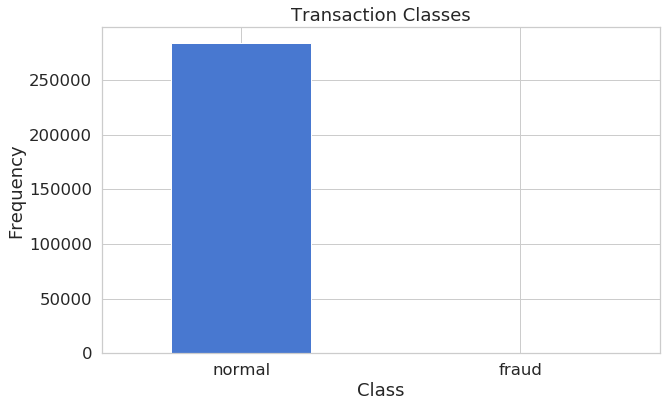

In [6]:
class_count = pd.value_counts(df['Class'], sort=True)
class_count.plot(kind='bar', rot=0)
plt.title("Transaction Classes")
plt.xticks(range(2), ['normal', 'fraud'])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [7]:
frauds = df[df.Class==1]
normal = df[df.Class==0]

### Prepare for autoencoder
- drop time column
- use standard scler on amount column

In [3]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data.head()
print(len(data.columns))
print(data.shape)

30
(284807, 30)


- only train on 'good' data
- drop the label

In [4]:
X_train, X_test = train_test_split(data[data['Class']==0], test_size=.25, random_state=37)
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'], axis=1)

y_test  = X_test['Class']
X_test  = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test  = X_test.values

- determine the shape of the input layer

In [10]:
X_train.shape

(213235, 29)

### Build the autoencoder for nominal data

In [5]:
input_dim    = X_train.shape[1]
encoding_dim = 20

in_layer = Input(shape=(input_dim,))

encoder  = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(1e-5))(in_layer)
encoder  = Dense(encoding_dim//2, activation='relu')(encoder)

decoder  = Dense(encoding_dim//2, activation='tanh')(encoder)
decoder  = Dense(encoding_dim, activation='relu')(decoder)

out_layer = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=in_layer, outputs=out_layer)

### Train the model

In [6]:
EPOCHS     = 32
BATCH_SIZE = 64

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_n.h5', verbose=0, save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

hist = autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_test, X_test), verbose=1, callbacks=[checkpoint, tensorboard]).history




Train on 213236 samples, validate on 71079 samples




Epoch 1/32
213236/213236 [==============================] - 6s 30us/step - loss: 0.7715 - acc: 0.6315 - val_loss: 0.6979 - val_acc: 0.7006
Epoch 2/32
213236/213236 [==============================] - 6s 28us/step - loss: 0.6892 - acc: 0.7247 - val_loss: 0.6733 - val_acc: 0.7294
Epoch 3/32
213236/213236 [==============================] - 6s 30us/step - loss: 0.6749 - acc: 0.7404 - val_loss: 0.6657 - val_acc: 0.7398
Epoch 4/32
213236/213236 [==============================] - 6s 29us/step - loss: 0.6654 - acc: 0.7527 - val_loss: 0.6579 - val_acc: 0.7629
Epoch 5/32
213236/213236 [==============================] - 6s 27us/step - loss: 0.6586 - acc: 0.7681 - val_loss: 0.6504 - val_acc: 0.7754
Epoch 6/32
213236/213236 [==============================] - 6s 28us/step - loss: 0.6555 - acc: 0.7740 - val_loss: 0.6514 - val_acc: 0.7700
Epoch 7/32
213236/213236 [==============================] - 6s 26us/step - loss: 0.6528 - acc: 0.7765 - val_

In [13]:
autoencoder = load_model('model.h5')

### Evaluation

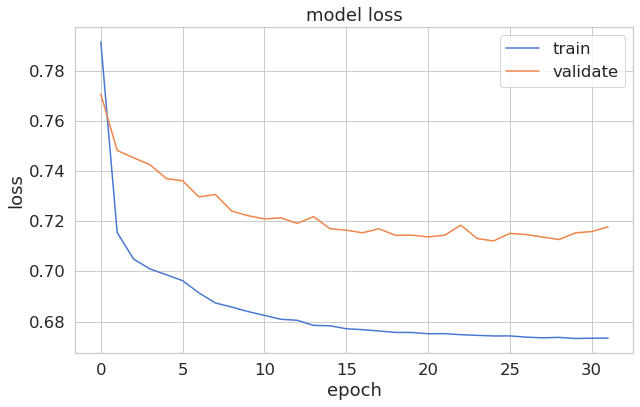

In [14]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'validate'], loc='best')
plt.show()

### Predict

In [15]:
preds  = autoencoder.predict(X_test)
mse    = np.mean(np.power(X_test - preds, 2), axis=1)
err_df = pd.DataFrame({'reconstruction_error': mse,
                      'true_class': y_test})
err_df.describe()

,reconstruction_error,true_class
count,71202.000000,71202.000000
mean,0.707980,0.001713
std,3.552790,0.041358
min,0.034212,0.000000
25%,0.203316,0.000000
50%,0.343262,0.000000
75%,0.570324,0.000000
max,309.423774,1.000000


### Reconstruction error of correct samples

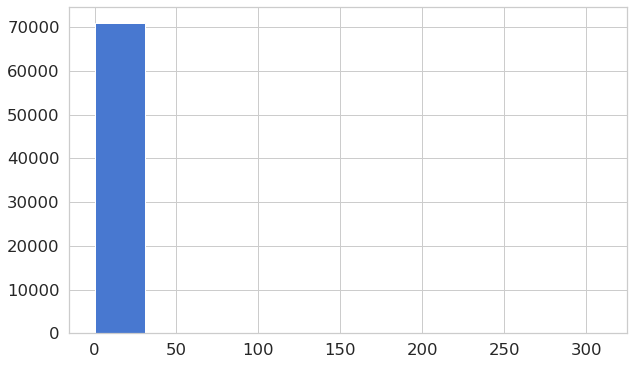

In [16]:
nominal_df = err_df[(err_df['true_class']==0)]
plt.hist(nominal_df.reconstruction_error.values)
plt.show()

### Reconstruction error of anomalous samples

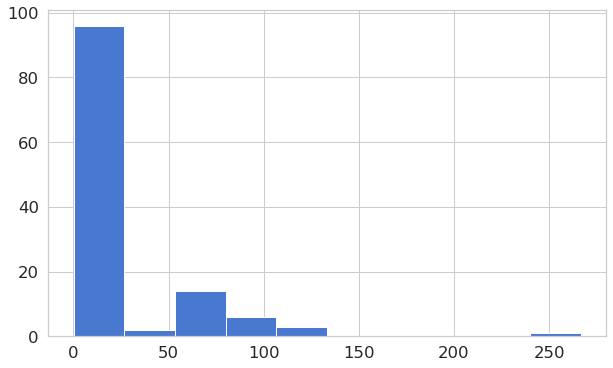

In [17]:
anomalous_df = err_df[(err_df['true_class']==1)]
plt.hist(anomalous_df.reconstruction_error.values)
plt.show()

### Deeper evaluation

In [18]:
from sklearn.metrics import *

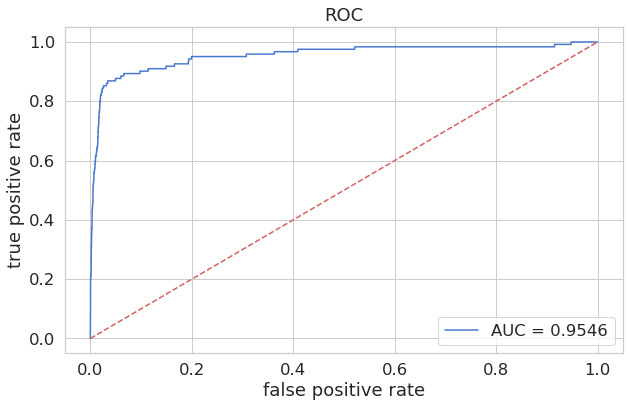

In [19]:
fpr, tpr, thresholds = roc_curve(err_df.true_class, err_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title("ROC")
plt.plot(fpr, tpr, label='AUC = %.4f'%roc_auc)
plt.legend(loc='best')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

### Precision and recall

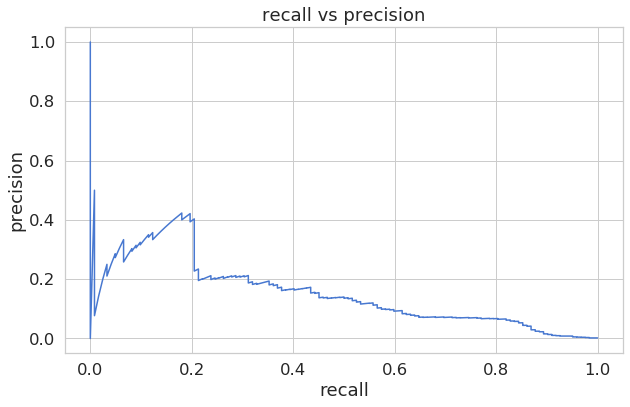

In [20]:
precision, recall, thresh = precision_recall_curve(err_df.true_class, err_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='p-r curve')
plt.title('recall vs precision')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

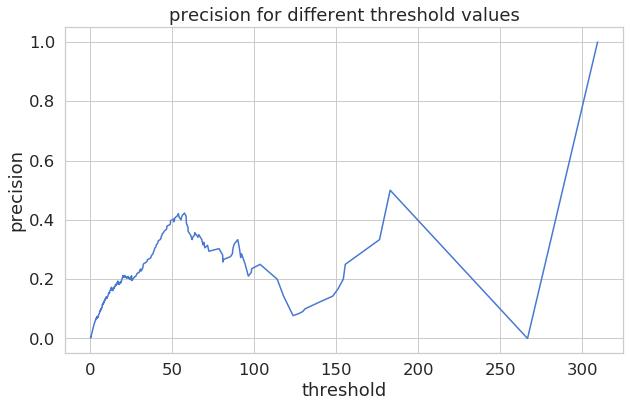

In [21]:
plt.plot(thresh, precision[1:], 'b', label='threshold-precision curve')
plt.title('precision for different threshold values')
plt.xlabel("threshold")
plt.ylabel("precision")
plt.show()

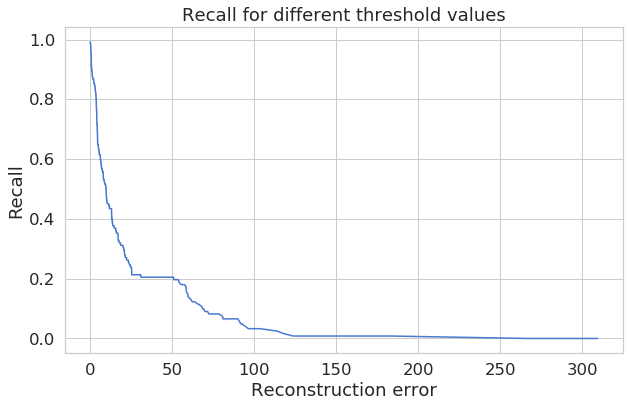

In [22]:
plt.plot(thresh, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

### Check the model performance 

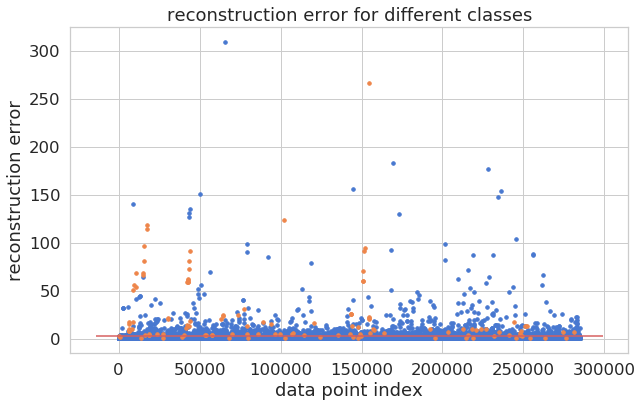

In [23]:
threshold = 2.9

groups = err_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', label="fraud" if name == 1 else "normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='threshold')
plt.title('reconstruction error for different classes')
plt.ylabel('reconstruction error')
plt.xlabel('data point index')
plt.show()

### Confusion matrix

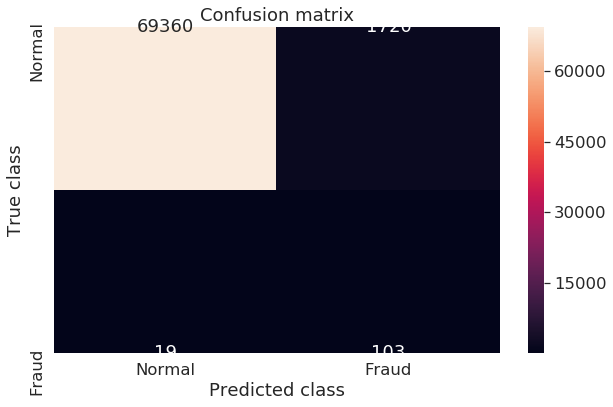

In [24]:
y_pred = [1 if e > threshold else 0 for e in err_df.reconstruction_error.values]

c = confusion_matrix(err_df.true_class, y_pred)
sns.heatmap(c, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt='d')
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import pickle

Using TensorFlow backend.


In [2]:
df = pd.read_csv('datasets/creditcard.csv')
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data.head()
print(len(data.columns))
print(data.shape)

30
(284807, 30)


In [3]:
goodSamples = data[data['Class']==0].sample(1)
goodSamples.head()
print(len(goodSamples))
all_bad = data[data['Class']==1]
print(len(all_bad))
data_A = pd.concat([goodSamples, all_bad])
print(len(data_A))

1
492
493


30
(284807, 30)


### Build the autoencoder for anomalous data

In [4]:
A_train, A_test = train_test_split(all_bad, test_size=.15, random_state=37)
#A_train, A_test = train_test_split(data, test_size=.15, random_state=37)
A_train = A_train[A_train.Class==1]
A_train = A_train.drop(['Class'], axis=1)

b_test  = A_test['Class']
A_test  = A_test.drop(['Class'], axis=1)

A_train = A_train.values
A_test  = A_test.values

input_dim    = A_train.shape[1]
encoding_dim = 20

in_layer_A = Input(shape=(input_dim,))

encoder_A  = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(1e-5))(in_layer_A)
encoder_A  = Dense(12, activation='relu')(encoder_A)

decoder_A  = Dense(12, activation='tanh')(encoder_A)
decoder_A  = Dense(encoding_dim, activation='relu')(decoder_A)

out_layer_A = Dense(input_dim, activation='relu')(decoder_A)

autoencoder_A = Model(inputs=in_layer_A, outputs=out_layer_A)

In [8]:
A_test.shape

(74, 29)

### Train the anomalous autoencoder

In [5]:
EPOCHS_A     = 256
BATCH_SIZE_A = 8

autoencoder_A.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint_A = ModelCheckpoint(filepath='model_A.h5', verbose=0, save_best_only=True)

tensorboard_A = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

hist_A = autoencoder_A.fit(A_train, A_train, epochs=EPOCHS_A, batch_size=BATCH_SIZE_A, verbose=0, shuffle=True, validation_data=(A_test, A_test), callbacks=[checkpoint_A, tensorboard_A]).history

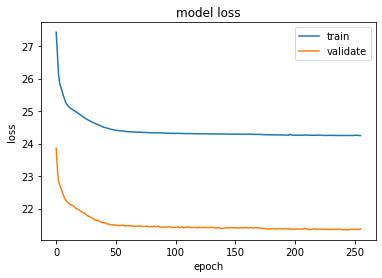

In [6]:
plt.plot(hist_A['loss'])
plt.plot(hist_A['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'validate'], loc='best')
plt.show()

In [7]:
preds_A  = autoencoder_A.predict(A_test)
mse_A    = np.mean(np.power(A_test - preds_A, 2), axis=1)
err_df_A = pd.DataFrame({'reconstruction_error': mse_A,
                      'true_class': b_test})
err_df_A.describe()

,reconstruction_error,true_class
count,74.000000,74.0
mean,21.369682,1.0
std,34.919808,0.0
min,0.354132,1.0
25%,3.519581,1.0
50%,9.725070,1.0
75%,20.495395,1.0
max,233.524623,1.0


### Check both models performance on the opposite data

In [8]:
aen = load_model('model_n.h5')
aea = load_model('model_A.h5')

In [46]:
goodSamples = data[data['Class']==0].sample(20).drop(['Class'], axis=1)
badSamples  = data[data['Class']==1].sample(20).drop(['Class'], axis=1)

### Check statistics for good encoder and good samples

In [47]:
preds_n_good  = aen.predict(goodSamples)
mse_n_good    = np.mean(np.power(goodSamples-preds_n_good,2), axis=1)
err_n_good_df = pd.DataFrame({'reconstruction_error': mse_n_good, 'true_class': 0})
print(err_n_good_df.describe())
print(err_n_good_df)

       reconstruction_error  true_class
count             20.000000        20.0
mean               0.383899         0.0
std                0.288342         0.0
min                0.092785         0.0
25%                0.142538         0.0
50%                0.285524         0.0
75%                0.572904         0.0
max                1.025781         0.0
        reconstruction_error  true_class
228748              0.668240           0
223933              0.299054           0
70626               0.129653           0
172576              0.378591           0
212001              0.287393           0
13920               0.145388           0
175768              0.763132           0
30048               0.092785           0
49140               0.678673           0
6159                0.283656           0
204375              0.942886           0
215918              1.025781           0
85312               0.214999           0
84818               0.114966           0
279809              0.253

### Check statistics for good encoder and bad samples

In [49]:
preds_n_bad  = aen.predict(badSamples)
mse_n_bad    = np.mean(np.power(badSamples-preds_n_bad,2), axis=1)
err_n_bad_df = pd.DataFrame({'reconstruction_error': mse_n_bad, 'true_class': 1})
print(err_n_bad_df.describe())
print(err_n_bad_df)

       reconstruction_error  true_class
count             20.000000        20.0
mean              21.179919         1.0
std               31.716044         0.0
min                0.393357         1.0
25%                4.012202         1.0
50%                9.634119         1.0
75%               16.696096         1.0
max              117.466481         1.0
        reconstruction_error  true_class
248971              2.766801           1
154286             14.732326           1
153823            117.466481           1
89190              14.790013           1
8972                6.911459           1
57615               3.888221           1
83053               4.037709           1
44091              19.658275           1
27627               4.097457           1
262560             12.336619           1
44270              92.493113           1
42528              59.436911           1
6329                5.880834           1
112840              0.393357           1
46998               3.935

### Check statistics for bad encoder and bad samples

In [50]:
preds_a_bad  = aea.predict(badSamples)
mse_a_bad    = np.mean(np.power(badSamples-preds_a_bad,2), axis=1)
err_a_bad_df = pd.DataFrame({'reconstruction_error': mse_a_bad, 'true_class': 1})
print(err_a_bad_df.describe())
print(err_a_bad_df)

       reconstruction_error  true_class
count             20.000000        20.0
mean              20.061239         1.0
std               29.657704         0.0
min                0.532773         1.0
25%                3.465014         1.0
50%                9.506767         1.0
75%               18.804909         1.0
max              107.713794         1.0
        reconstruction_error  true_class
248971              2.123096           1
154286             19.283547           1
153823            107.713794           1
89190              12.057441           1
8972                8.288050           1
57615               3.468710           1
83053               3.451798           1
44091              18.645363           1
27627               3.619586           1
262560             11.227442           1
44270              89.076842           1
42528              55.803482           1
6329                3.812605           1
112840              0.532773           1
46998               3.453

### Check statistics for bad encoder and good samples

In [51]:
preds_a_good  = aea.predict(goodSamples)
mse_a_good    = np.mean(np.power(goodSamples-preds_a_good,2), axis=1)
err_a_good_df = pd.DataFrame({'reconstruction_error': mse_a_good, 'true_class': 0})
print(err_a_good_df.describe())
print(err_a_good_df)

       reconstruction_error  true_class
count             20.000000        20.0
mean               0.706337         0.0
std                0.425895         0.0
min                0.210841         0.0
25%                0.357004         0.0
50%                0.620081         0.0
75%                0.930555         0.0
max                1.840296         0.0
        reconstruction_error  true_class
228748              0.799177           0
223933              0.629422           0
70626               0.307207           0
172576              0.815629           0
212001              0.316389           0
13920               0.610739           0
175768              1.251518           0
30048               0.318854           0
49140               1.007921           0
6159                0.904766           0
204375              1.840296           0
215918              1.191280           0
85312               0.410374           0
84818               0.369720           0
279809              0.436

### Check mse of good sample going thru good encoder

In [39]:
s = goodSamples.iloc[3:4]
preds_n_good_sample = aen.predict(s)
mse_n_good_sample   = np.mean(np.power(s-preds_n_good_sample, 2), axis=1)
print(mse_n_good_sample)

220146    0.193042
dtype: float64


### Check mse of bad sample going thru good encoder

In [37]:
s = badSamples.iloc[3:4]
preds_n_bad_sample = aen.predict(s)
mse_n_bad_sample   = np.mean(np.power(s-preds_n_bad_sample, 2), axis=1)
print(mse_n_bad_sample)

83297    8.139546
dtype: float64


### Check mse of good sample going thru bad encoder

In [40]:
s = goodSamples.iloc[3:4]
preds_a_good_sample = aea.predict(s)
mse_a_good_sample   = np.mean(np.power(s-preds_a_good_sample, 2), axis=1)
print(mse_a_good_sample)

220146    0.280712
dtype: float64


### Check mse of bad sample going thru bad encoder

In [41]:
s = badSamples.iloc[3:4]
preds_a_bad_sample = aea.predict(s)
mse_a_bad_sample   = np.mean(np.power(s-preds_a_bad_sample, 2), axis=1)
print(mse_a_bad_sample)

83297    7.528955
dtype: float64
